In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install gpy

In [3]:
import GPy

In [24]:
np.random.seed(0)

In [25]:
def mog_pdf(xs, ms, sigmas, weights):
    w = 1e4*np.random.randn()
    w2 = 1e4 * np.random.randn()
    def f(x):
      z = np.exp(-(np.stack([x]*len(mus), axis=1) - mus)**2/sigmas)
      eta = 0.0 * (np.sin(w*x) + np.cos(w2*x))
      res = np.sum(z*weights, axis=-1) + eta
      return res
    return f(xs), f


In [26]:
x = np.arange(-10, 10, 0.035)
n = 5
mus = [-5.5, -3.5] + [i/n*7 - 0.5 for i in range(n)]
y, f = mog_pdf(x, mus, [1.2, 1.2] + [0.2] * n, [1.3, 1.0] + [0.55] * n)
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.5)


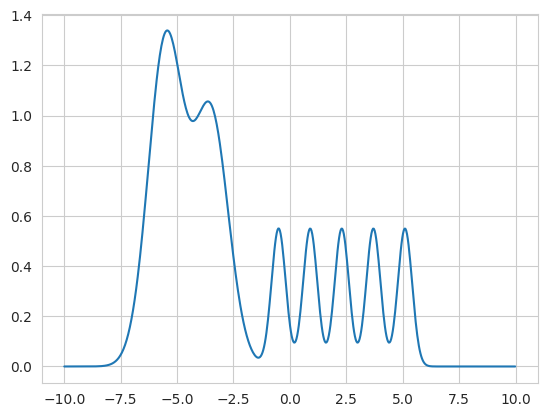

In [27]:
plt.plot(x, y)

In [28]:
def noise_function_builder(lengthscale, logit_transform):
  kernel = GPy.kern.src.rbf.RBF(input_dim=1, lengthscale=lengthscale)

  def noise_fn(x, num_samples=20):
    if len(x.shape) == 1:
      x = x.reshape(-1,1)

    cov = kernel.K(x, x)
    gp_outs = np.random.multivariate_normal(np.zeros(x.shape[0]), cov, size=num_samples)
    transformed_logits = logit_transform(gp_outs)
    probs = 1/(1+np.exp(-transformed_logits))
    return np.random.binomial(1, probs)
  return noise_fn
nf = noise_function_builder(0.5, lambda x : (x - np.pi/2)*50)


In [29]:
def select_builder(xs, threshold=0.75, subset_size=15):
  if len(xs.shape)==2:
    xs = xs.reshape(-1)
  def subset_select(ys):
    selected = []
    available = list(range(len(ys)))

    for i in range(subset_size):
      if len(available) > 0:
        avail_arr = np.asarray(available).astype(int)
        max_idx = np.argmax(ys[avail_arr])
        idx = avail_arr[max_idx]
        selected.append(idx)
        for j in avail_arr:
            if np.linalg.norm(xs[j] - xs[idx]) < threshold:
              available.remove(j)
    return np.asarray(selected)
  return subset_select

In [30]:
def noisy_evaluate(model, x, y, noise_fn, num_samples=50):
  ss = select_builder(x, threshold=0.5)
  if x.shape == 1:
    x = x.reshape(-1, 1)
  eta = noise_fn(x, num_samples=num_samples)
  f, _ = model.predict(x.reshape(-1,1))
  idxes = ss(f)
  fs = np.stack([y.reshape(-1)]*num_samples)
  ef = eta*fs
  return np.mean(np.max(ef[:, idxes], axis=-1), axis=0), x[idxes], np.max(ef[:, idxes], axis=-1)

In [31]:
def plot_results(model, x, y, nf, plot_title="", num_samples=5000, ax=None, seed=0):
  if ax is None:
    ax = plt.gca()
  np.random.seed(seed)
  model.plot(plot_density=False, ax=ax, legend=False)
  score, selected, all = noisy_evaluate(model, x, y, nf, num_samples=num_samples)
  std = np.std(all)/np.sqrt(num_samples)
  ax.text(-6.9, -0.91, f"Score = {score:0.03f} $\pm$ {std:0.03f}", fontsize="xx-large")
  ax.scatter(selected, np.zeros(len(selected)), marker="*", color="purple", label="$\mathcal{A}(\hat{F}))$")
  ax.plot(x, y, color='red', label="f(x)")
  ax.set_title(plot_title, fontsize="x-large")
  ax.set_xlabel("x", fontsize="x-large")
  ax.set_ylabel("f(x)", fontsize="x-large")
  ax.set_xlim(np.min(x), np.max(x))


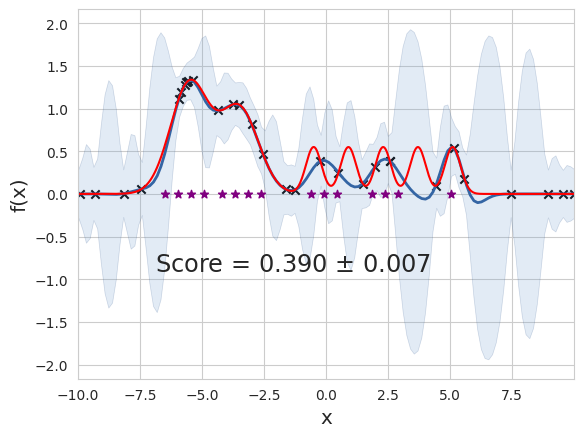

In [32]:
sns.set_style('whitegrid')
def thompson_sampling(model, xs, ys, num_samples=25):
  sampled_points = []
  idx = np.random.choice(len(xs))
  x_t = [xs[idx]]
  y_t = [ys[idx]]
  for i in range(num_samples):
    y_t = np.concatenate([y_t, [ys[idx]]])
    x_t = np.concatenate([x_t, [xs[idx]]])

    curr_model = model(x_t.reshape(-1,1), y_t.reshape(-1,1))
    sample_ys = curr_model.posterior_samples(xs.reshape(-1,1), size=1)[:, 0, 0]
    idx = np.argmax(sample_ys)
    sampled_points.append(idx)
  return curr_model

model_fn = lambda x, y : GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
ts_model = thompson_sampling(model_fn, x, y, num_samples=30)
plot_results(ts_model, x, y, nf)


In [ ]:
def active_sampling(model, xs, ys, num_samples=25):
  sampled_points = []
  idx = np.random.choice(len(xs))
  x_t = [xs[idx]]
  y_t = [ys[idx]]
  not_yet_seen = set(list(range(len(xs))))
  for i in range(num_samples):
    x_t = np.concatenate([x_t, [xs[idx]]])
    y_t = np.concatenate([y_t, [ys[idx]]])
    curr_model = model(x_t.reshape(-1,1), y_t.reshape(-1,1))
    means, vars = curr_model.predict(xs.reshape(-1,1))
    idx = np.argmax(vars)
  curr_model.plot(x=xs.reshape(-1,1), plot_density=False)
  return curr_model


model_fn = lambda x, y : GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
as_model =active_sampling(model_fn, x, y)
plot_results(as_model, x, y, nf)

In [ ]:
def ucb_sampling(model, xs, ys, num_samples=25, alpha=1.5):
  sampled_points = []
  idx = len(xs)-1 # Need to ensure edge sampled for plotting to work
  x_t = [xs[idx]]
  y_t = [ys[idx]]
  not_yet_seen = set(list(range(len(xs))))
  for i in range(num_samples):
    x_t = np.concatenate([x_t, [xs[idx]]])
    y_t = np.concatenate([y_t, [ys[idx]]])
    curr_model = model(x_t.reshape(-1,1), y_t.reshape(-1,1))
    means, vars = curr_model.predict(xs.reshape(-1,1))
    ucbs = means + alpha * np.sqrt(vars)
    unseen_list = np.array(list(not_yet_seen)).astype(int)
    unseen_list.sort()
    idx = np.argmax(ucbs[unseen_list])
    idx = unseen_list[idx]
    not_yet_seen.remove(idx)
  curr_model.plot(x=xs.reshape(-1,1), plot_density=False)
  return curr_model


model_fn = lambda x, y : GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
uc_model = ucb_sampling(model_fn, x, y)


In [ ]:
def random_sampling(model, xs, ys, num_samples=25):
  sampled_points = []
  idx = np.random.choice(len(xs))
  x_t = [xs[idx]]
  y_t = [ys[idx]]
  not_yet_seen = set(list(range(len(xs))))
  for i in range(num_samples):
    x_t = np.concatenate([x_t, [xs[idx]]])
    y_t = np.concatenate([y_t, [ys[idx]]])
    curr_model = model(x_t.reshape(-1,1), y_t.reshape(-1,1))
    unseen_list = np.array(list(not_yet_seen)).astype(int)
    unseen_list.sort()
    idx = np.random.choice(unseen_list)
    not_yet_seen.remove(idx)

  return curr_model


In [ ]:
def bax_sampling(model, xs, ys, algo, num_samples=25, posterior_budget=10):
  sampled_points = []
  idx = np.random.choice(len(xs))
  x_t = np.asarray([xs[idx]])
  y_t = np.asarray([ys[idx]])
  for i in range(num_samples):
    curr_model = model(x_t.reshape(-1,1), y_t.reshape(-1,1))
    posteriors = curr_model.posterior_samples(xs.reshape(-1,1), size=posterior_budget).reshape(-1, posterior_budget).T
    outs = [algo(p) for p in posteriors]
    out_idxes = [o.astype(int) for o in outs]
    entropies = []
    for i, out in enumerate(out_idxes):
      new_x = np.concatenate([x_t, xs[out].reshape(-1)])
      new_y = np.concatenate([y_t, posteriors[i][out].reshape(-1)])
      new_model = model(new_x.reshape(-1,1), new_y.reshape(-1,1))
      new_vars = new_model.predict(xs.reshape(-1,1))[1]
      entropies.append(1/2*np.log(2*np.pi*new_vars))
    hxs = np.asarray(entropies).mean(axis=0)
    post_entropy = 1/2 * np.log(2*np.pi*curr_model.predict(xs.reshape(-1,1))[1])
    eigs = []
    eigs = post_entropy - hxs
    idx = np.argmax(eigs)
    x_t = np.concatenate([x_t, [xs[idx]]])
    y_t = np.concatenate([y_t, [ys[idx]]])
  return curr_model

# Dummy algo
def algo(x):
  return np.where(x>0.4)[0]

model_fn = lambda x, y: GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
bs_model = bax_sampling(model_fn, x, y, algo, num_samples=30)
plot_results(bs_model, x, y, nf)

In [ ]:
def algo(x):
  return np.where(x>1)[0]
model_fn = lambda x, y: GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
ls1_model = bax_sampling(model_fn, x, y, algo, num_samples=30)
plot_results(ls1_model, x, y, nf)

In [ ]:
def top_k(x, k=10):
  return np.argsort(x[-k:])
model_fn = lambda x, y: GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
tk_model = bax_sampling(model_fn, x, y, top_k, num_samples=30)
plot_results(tk_model, x, y, nf)

In [ ]:
model_fn = lambda x, y : GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
selector = select_builder(x)
ssm_model = bax_sampling(model_fn, x, y, selector, num_samples=30)


In [ ]:
# Ground-truth model
model_fn = lambda x, y : GPy.models.GPRegression(x, y, kernel, noise_var=0.01)
selector = select_builder(x)
gt_model = model_fn(x.reshape(-1,1), y.reshape(-1,1))

In [ ]:
titles=["Active Sampling",
        "Thompson Sampling",
        "UCB",
        "DiscoBax",
        "top-k BAX",
        "Levelset(1) BAX",
        "Levelset(0.4) BAX",
        "Ground Truth"]
fig, axs = plt.subplots(2, 4, figsize=(18, 8*(18/20)))
for i, model in enumerate([as_model, ts_model, uc_model, ssm_model, tk_model, ls1_model, bs_model, gt_model]):
  plot_results(model, x, y, nf, plot_title=titles[i], num_samples=20_000, ax=axs[i//4][i%4], seed=0)

axs[0][0].legend(loc="upper right")
fig.suptitle("Mixture of Gaussians Illustration", fontsize="xx-large", y=1.05)
fig.tight_layout()